# GP regression with heteroscedasic noise
## Pyro implementation demo notebook

In [65]:
import torch
import pyro
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import GP regression code
from importlib import reload
import dli_gpr

%matplotlib inline

## Loading input data

In [233]:
import os

# read input data
test_fname_r = os.path.join("data", "v3_MetaclusterTE_R_gprinput.txt")
test_fname_nr = os.path.join("data", "v3_MetaclusterTE_NR_gprinput.txt")
test_df_r = pd.read_csv(test_fname_r, sep="\t", header=0)
test_df_nr = pd.read_csv(test_fname_nr, sep="\t", header=0)

# get rid of rows with NaN
test_df_r.dropna(inplace=True)

# get rid of rows with NaN
test_df_nr.dropna(inplace=True)

test_df_r

,time,proportion(y),numcellsincluster(x),totalcellsinsample(n),patientID,sampleID,tumorburden
0,-30,0.0000,1,329,DFCI-5310,1,94.0
1,180,0.0931,21,1310,DFCI-5310,2,0.0
2,-42,0.1725,127,2834,DFCI-5309,5,11.0
3,90,0.0808,88,2030,DFCI-5309,6,0.0
4,0,0.3389,7,3184,DFCI-5311,9,44.0
6,90,0.2036,32,3762,DFCI-5311,11,0.0
7,270,0.0487,24,8662,DFCI-5311,12,0.0
8,0,0.4367,116,1358,DFCI-5312,21,38.0
9,270,0.0000,1,13,DFCI-5312,22,0.0
10,-5,0.1644,10,1174,DFCI-5317,23,80.0


In [234]:
test_df_nr

,time,proportion(y),numcellsincluster(x),totalcellsinsample(n),patientID,sampleID,tumorburden
0,-30,0.0506,1,791,DFCI-5322,3,100.0
1,165,0.0935,15,759,DFCI-5322,4,100.0
2,0,0.1418,241,1692,DFCI-5324,7,93.0
4,-14,0.0771,1,1804,DFCI-5325,17,100.0
5,730,0.1688,736,3756,DFCI-5325,18,100.0
6,-4,0.1195,39,1515,DFCI-5326,19,100.0
7,120,0.0466,36,5409,DFCI-5326,20,100.0
8,0,0.3891,49,1627,DFCI-5318,27,100.0
9,182,0.3800,4,771,DFCI-5318,28,100.0
10,-543,0.3027,3,2709,DFCI-5322,33,0.0


## Show some descriptive statistics

In [241]:
tb_r = test_df_r["tumorburden"].values
tb_nr = test_df_nr["tumorburden"].values

print("Mean tumor burden, responders: ", np.mean(tb_r))
print("Mean tumor burden, non-responders: ", np.mean(tb_nr))

print("Variance of tumor burden, responders: ", np.var(tb_r))
print("Variance of tumor burden, non-responders: ", np.var(tb_nr))

print("Overall variance: ", np.var(np.concatenate([tb_r, tb_nr])))
print("Standard error: ", np.var(np.concatenate([tb_r, tb_nr]))/(len(tb_r) + len(tb_nr)))

Mean tumor burden, responders:  31.65
Mean tumor burden, non-responders:  76.6875
Variance of tumor burden, responders:  1494.1274999999998
Variance of tumor burden, non-responders:  1570.46484375
Overall variance:  2028.8888888888885
Standard error:  56.35802469135801


In [243]:
diffs = tb_r[1:] - tb_r[:-1]
print(np.var(diffs))

3828.891966759003


In [248]:
np.var(tb_r[np.argsort(test_df_r["time"].values)])/len(diffs)

78.63828947368421

## Preparing model input

Below we prepare two models: one to describe tumor burden and one to describe the proportion of cells found in that metacluster.

In [358]:
# prepare torch tensor for time points
y = torch.FloatTensor(test_df_r.time.values)

# reponse variables (one for metclusters, one for tumor burden)
metacluster = torch.FloatTensor(test_df_r["proportion(y)"].values)
tumorburden = torch.FloatTensor(tb_r / 100.)

# number of cells size in each time point
cluster_sizes = torch.FloatTensor(test_df_r["totalcellsinsample(n)"].values)

## Model initialization and optimization

In [373]:
reload(dli_gpr)

# tumor burden model
tumor_model = dli_gpr.gpr(y, tumorburden)

# metacluster model
metacluster_model = dli_gpr.dli_gpr(y, metacluster, cluster_sizes)

# initialize kernel and center the response variable
tumor_model.initialize_variables()
metacluster_model.initialize_variables()

print("Variances")
print("Tumor burden: ", tumor_model.sigma.item())
print("Metacluster: ", 1./metacluster_model.gam.item())

Variances
Tumor burden:  0.007863828912377357
Metacluster:  0.0015130525252896516


### Optimize each model
We will run 2000 iterations of SVI for each model.

In [376]:
pyro.clear_param_store()
losses1 = tumor_model.optimize(n_steps=5000)

pyro.clear_param_store()
losses2 = metacluster_model.optimize(n_steps=2000)

100%|██████████| 2000/2000 [00:03<00:00, 543.23it/s]


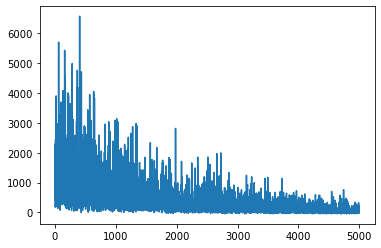

In [368]:
plt.plot(losses1)

In [367]:
print(tumor_model.sigma)
print(1./metacluster_model.gam)

tensor(0.0947)
tensor(0.0035)


## Results visualization
We compute the conditional distribution of each response variable at a number of new input points to model what our data should have looked like at intermediate points.

In [378]:
# new input time points
new_y = torch.FloatTensor(np.linspace(-600, 1200, 100))

# compute conditional distribution of response variable
new_tumor, cov_tumor = tumor_model.conditional_distribution(new_y)
new_metacluster, cov_metacluster = metacluster_model.conditional_distribution(new_y)

Text(0.5, 1.0, 'Metacluster proportion')

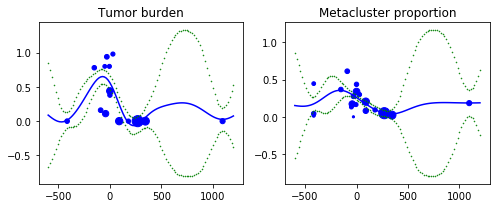

In [379]:
# make a plot
sizes = cluster_sizes.numpy()/70

# time points as numpy array
new_times = new_y.numpy()

# means
tumor_mean = new_tumor.numpy()
metacluster_mean = new_metacluster.numpy()

# plus or minus standard deviation
tumor_std = torch.diag(cov_tumor).numpy()#**0.5
metacluster_std = torch.diag(cov_metacluster).numpy()#**0.5

# make plots
fig, ax = plt.subplots(1,2, figsize=(7,3), tight_layout=True)

# plot tumor
ax[0].plot(new_times, tumor_mean, "b-")
ax[0].scatter(y.numpy(), tumorburden.numpy(), s=sizes, c="b")
ax[0].scatter(new_times, tumor_mean + tumor_std, c="g", s=0.3)
ax[0].scatter(new_times, tumor_mean - tumor_std, c="g", s=0.3)
ax[0].set_title("Tumor burden")

# plot tumor
ax[1].plot(new_times, metacluster_mean, "b-")
ax[1].scatter(y.numpy(), metacluster.numpy(), s=sizes, c="b")
ax[1].scatter(new_times, metacluster_mean + metacluster_std, c="g", s=0.3)
ax[1].scatter(new_times, metacluster_mean - metacluster_std, c="g", s=0.3)
ax[1].set_title("Metacluster proportion")

In [318]:
tumor_model.lamb

tensor(285.)